# Toy Example
Goal: to prove the advantages of using a factored MDP (factored dynamics, rewards, values) on a simple manipulator task. 

In [152]:

import math
import numpy as np
import torch
from time import time
import matplotlib.pyplot as plt
import matplotlib.animation as animation


## Model

### Definition

In [153]:

L1, L2, L3 = 10, 20, 5
GOAL_POSITIONS = [10, -25]
INITIAL_POSITIONS = [-10, -20]

def dist_fn(x, y):
    x = np.array(x)
    y = np.array(y)
    return np.linalg.norm(x - y, ord=2) 

class ManipulatorModel(object):
    """
        A class of a 3-link manipulator
    """
    def __init__(self, factored=False):
        self.factored = factored
        self.num_links = 3
        self.actuators = [0 for i in range(self.num_links)]
        self.action_scale = np.array([[0, 2*math.pi], [0, math.pi], [0, math.pi]]) 

    def step(self, z, action=None):
        '''
            Args:
                z: states (end-effector or joint positions)
                action: absolute actions of the joints
        
        '''
        if self.factored:
            current_angles = z
        else:
            current_angles, _ = inverse_kinematics(*z)

        # TODO: add actuators
        if action is not None:
            desired_angles = 0.5 * (action+1) * (self.action_scale[:, 1] - self.action_scale[:, 0]) + self.action_scale[:, 0]
            joint_angles = current_angles + np.clip(desired_angles - current_angles, -0.01, 0.01)
        else:
            joint_angles = current_angles 

        link_poses = forward_kinematics(*joint_angles)
        ee_pose = link_poses['Link3']
        goal_error = dist_fn(ee_pose, GOAL_POSITIONS) 

        if self.factored:
            next_obs = joint_angles
            reward = np.array([ - dist_fn([joint_angles[i]], [GOAL_ANGLES[i]]) for i in range(self.num_links)])
        else:
            next_obs = ee_pose
            reward = - dist_fn(ee_pose, GOAL_POSITIONS)
        
        done = False
        if np.sum(-reward) < 1e-3:  # closed to the target
            done = True

        info = {'Link_Pose': link_poses, 'EE_Pose': ee_pose, 'Goal_Error': goal_error, 'Theta': joint_angles}
        return next_obs, reward, done, info

# Define Forward Kinematics
def forward_kinematics(T1, T2, T3):
    '''   
    This function gives end effector position
    It takes 6 arguments:
    Where,
    Li = length of Link i 
    Ti = Angular Position of i Link in radians
    '''   
   
    # Link coordinates of Arm 1
    x1 = L1*math.cos(T1) 
    y1 = L1*math.sin(T1)   

    # Link Coordinates of Arm 2
    x2 = x1 + L2*math.cos(T1 + T2) 
    y2 = y1 + L2*math.sin(T1 + T2)
    
    # Link Coordinates of Arm 3
    x3 = x2 + L3*math.cos(T1 + T2 + T3) 
    y3 = y2 + L3*math.sin(T1 + T2 + T3)

    Sol = {'Link1' : (x1,y1), 'Link2' : (x2,y2), 'Link3' : (x3,y3)}        
    return(Sol)

def inverse_kinematics(X, Y):
    
    '''
    This function returns set of possible solutions for the joint angles
    The inverse kinematics are calculated on the basis of the Jacobian Matrix
    
    Here, 
    L1, L2, L3 are link lengths.
    X and Y are desired Coordinates
    '''
    # Initialize Theta Variables (In radians)
    
    # Th1 = 0.1*math.pi/180
    # Th2 = 0.1*math.pi/180
    # Th3 = 0.1*math.pi/180
    Th1 = math.pi
    Th2 = 0.5*math.pi
    Th3 = 0.5*math.pi
    
    Theta_vect = [Th1, Th2, Th3]
    Goal = np.array([[X], [Y]])
    
    # Calculate Jacobian matrix and related vectors
    
    def CalcJacobian(L1, L2, L3, Th1, Th2, Th3): 
        S1 = math.sin(Th1)
        S12 = math.sin(Th1 + Th2)
        S123 = math.sin(Th1 + Th2 + Th3)
        C1 = math.cos(Th1)
        C12 = math.cos(Th1 + Th2)
        C123 = math.cos(Th1 + Th2 + Th3)
    
        Jacobian = np.matrix([[-(L1*S1 + L2*S12 + L3*S123), -(L2*S12 + L3*S123), -L3*S123],
                              [(L1*C1 + L2*C12 + L3*C123), (L2*C12 + L3*C123), L3*C123]])
    
        return Jacobian
    
    errorThresh = 0.01 # Error Threshold value
    K = 0.001 # M: smaller value for stablility 0.003 # learning rate
    #prfint('I amath.at Inverse Kinemath.tics')
           
    CurrentPos = forward_kinematics(Th1, Th2, Th3)
    Xc = CurrentPos['Link3'][0]
    Yc = CurrentPos['Link3'][1]
    D = math.sqrt((Xc - X)**2 + (Yc - Y)**2)
    
    # Iterative Correction
    counts = 0
    x_iter = 500 # Adjust this if solution is not available 
    Errorlog = []
    while D > errorThresh:
        
        Jacobian = CalcJacobian(L1, L2, L3, Th1, Th2, Th3)
        
        # Simath.le Jacobian Inverse math.thod -> Requires conversion of Jacobian to Square math.trix 
        #Jacobian_inv = np.linalg.inv(Jacobian)  
        
        # Pseudo Inverse math.thod -> Works for Non square math.trix
        
        #Jacobian_pseudoinv = np.dot(np.linalg.inv(np.dot(Jacobian.T, Jacobian)), Jacobian.T)
        
        # Transpose math.thod -> Simath.le Transpose of Jacobian math.trix instead of inverse
        # Note -> In math. tests, Jacobian Transpose has given best results with least run timath.
        
        Jacobian_transpose = Jacobian.T
        
        adjust = np.array([[(X - Xc)], [(Y - Yc)]]) # Error in Positions of End Effector
    
        # Angular Displacemath.nt
    
        delta_theta = Jacobian_transpose * K * adjust # Angular Displacemath.nt Vector
        Th1 += delta_theta[0][0].item()
        Th2 += delta_theta[1][0].item()
        Th3 += delta_theta[2][0].item()
    
        # Update Current Position and Theta Vector
    
        CurrentPos = forward_kinematics(Th1, Th2, Th3)
        Xc = CurrentPos['Link3'][0]
        Yc = CurrentPos['Link3'][1]
        
        Theta_vect = [Th1, Th2, Th3]
        
        # Distance between the current and desired position of end effector
    
        D = math.sqrt((Xc - X)**2 + (Yc - Y)**2)
        Errorlog.append(D)
        
        # print('Iteration Count: ', counts)
        # print('Still Correcting. D = ', D)
        
        # Update Paramath.ters
        counts += 1
        
        #Avoid Infinite Loop
        if counts > x_iter:
            print(f'[Warning] inverse_kinematic Solution is not optimal with error: {D}')
            break

    return Theta_vect, Errorlog        

GOAL_ANGLES, _ = inverse_kinematics(*GOAL_POSITIONS)
INITIAL_ANGLES, _ = inverse_kinematics(*INITIAL_POSITIONS)
print(f'\n=== Model Created! ===\nL1:{L1} L2:{L2} L3:{L3}\nGoal Position: {GOAL_POSITIONS} Goal Angles:{GOAL_ANGLES}')
print(f'Initial Position: {INITIAL_POSITIONS} Initial Angles:{INITIAL_ANGLES}')



=== Model Created! ===
L1:10 L2:20 L3:5
Goal Position: [10, -25] Goal Angles:[4.076760543423507, 1.214153656419638, 0.9523784711378871]
Initial Position: [-10, -20] Initial Angles:[3.059370553461429, 1.4090946455303495, 1.5301193903162547]


### Visualization

In [154]:
# Setup Animation Environment

def visualize_planner(model, planner, name='random'):

    fig2 = plt.figure()
    axlimit = L1 + L2 + L3 + 5 
    anim = fig2.add_subplot(111, aspect = 'equal', autoscale_on = False, xlim = (-axlimit, axlimit), ylim = (-axlimit, axlimit))
    anim.grid(color = 'grey', linestyle = '-', linewidth = 0.5)  
    plt.title('Kinematic Solver | Point to Point Tracking') 
    link1, = anim.plot([], [], 'o-', lw = 4, mew = 5, label = "Link 1", color = 'Green')
    link2, = anim.plot([], [], 'o-', lw = 4, mew = 5, label = "Link 2", color = 'Blue')
    link3, = anim.plot([], [], 'o-', lw = 4, mew = 5, label = "Link 3", color = 'orange')
    link1trace, = anim.plot([], [], '-', lw = 0.5, mew = 1, color = 'Green')
    link2trace, = anim.plot([], [], '-', lw = 0.5, mew = 1, color = 'Blue')
    link3trace, = anim.plot([], [], '-', lw = 0.5, mew = 1, color = 'orange')

    time_template = 'Time = %.1fs'
    time_text = anim.text(0.02, 0.95, '', transform = anim.transAxes)
    Joint1_template = 'Joint 1 Pose = %.1f radians'
    Joint2_template = 'Joint 2 Pose = %.1f radians'
    Joint3_template = 'Joint 3 Pose = %.1f radians'
    Joint1_text = anim.text(0.02, 0.90, '', transform = anim.transAxes)
    Joint2_text = anim.text(0.02, 0.85, '', transform = anim.transAxes)
    Joint3_text = anim.text(0.02, 0.80, '', transform = anim.transAxes)

    ee_template = 'End Effector Position = %.1f, %.1f'
    ee_text = anim.text(0.02, 0.75, '', transform = anim.transAxes)
    error_template = 'Goal Error = %.2f'
    error_text = anim.text(0.02, 0.7, '', transform = anim.transAxes)

    dt = 1./10
    num_steps = 100

    # Plot Workspace Envelope
    plt.plot(GOAL_POSITIONS[0], GOAL_POSITIONS[1], marker='D', markersize=10, color='r')

    # Initialize states
    if model.factored:
        z = INITIAL_ANGLES
    else:
        z = INITIAL_POSITIONS
    # Initialize Vector for storing Link Coordinates
    X1, Y1, X2, Y2, X3, Y3, J1, J2, J3 = [], [], [], [], [], [], [], [], [] 

    Errorlog = []

    start_time = time()

    for t in range(num_steps):
        print(f'step: {t}')
        if t == 0:
            action = planner.plan(z, t0=True)
            next_z, reward, done, info = model.step(z, action=None)
        else:
            action = planner.plan(z, t0=False)
            next_z, reward, done, info = model.step(z, action)
        z = next_z

        Link_Pose = info['Link_Pose']
        Theta = info['Theta']
        EE_Pose = info['EE_Pose']

        X1.append(Link_Pose['Link1'][0])
        Y1.append(Link_Pose['Link1'][1])
        X2.append(Link_Pose['Link2'][0])
        Y2.append(Link_Pose['Link2'][1])
        X3.append(Link_Pose['Link3'][0])
        Y3.append(Link_Pose['Link3'][1])
        J1.append(Theta[0])
        J2.append(Theta[1])
        J3.append(Theta[2])     
        Errorlog.append(info['Goal_Error'])

    X = X3
    Y = Y3

    print('Calculation Time: %s seconds ' % (time() - start_time))    
    print(f'Control Steps: {num_steps} Control Interval: {dt}')

    # Update the Plot
    def init():
        link1.set_data([], [])
        link2.set_data([], [])
        link3.set_data([], [])
        
        time_text.set_text('')
        Joint1_text.set_text('')
        Joint2_text.set_text('')
        Joint3_text.set_text('')
        ee_text.set_text('')
        error_text.set_text('')
        return link1, link2, link3, Joint1_text, Joint2_text, Joint3_text, time_text, ee_text, error_text

    def animate(a):
        link1_x = X1[a] 
        link1_y = Y1[a]
        link2_x = X2[a] 
        link2_y = Y2[a]
        link3_x = X3[a] 
        link3_y = Y3[a]
        
        link1.set_data([0,link1_x],[0,link1_y])
        link2.set_data([link1_x,link2_x],[link1_y,link2_y])
        link3.set_data([link2_x,link3_x],[link2_y,link3_y])
        link1trace.set_data(X1,Y1)
        link2trace.set_data(X2,Y2)
        link3trace.set_data(X3,Y3)
        
        time_text.set_text(time_template % (a*dt))
        Joint1_text.set_text(Joint1_template % (J1[a]))
        Joint2_text.set_text(Joint2_template % (J2[a]))
        Joint3_text.set_text(Joint3_template % (J3[a]))
        ee_text.set_text(ee_template % (X[a], Y[a]))
        error_text.set_text(error_template % (Errorlog[a]))
    
        return link1, link2, link3, Joint1_text, Joint2_text, Joint3_text, time_text, ee_text, ee_text, ee_text, ee_text, error_text

    t0 = time()
    animate(0)
    t1 = time()
    # interval = 10000 * dt - (t1 - t0)
    interval = dt

    ani = animation.FuncAnimation(fig2, animate, np.arange(1, num_steps), interval = interval, blit = True, init_func = init)
    ani.save(f'{name}.mp4', fps = 1.0/dt)
    # plt.show()




## Random Planner

step: 0
step: 1
step: 2
step: 3
step: 4
step: 5
step: 6
step: 7
step: 8
step: 9
step: 10
step: 11
step: 12
step: 13
step: 14
step: 15
step: 16
step: 17
step: 18
step: 19
step: 20
step: 21
step: 22
step: 23
step: 24
step: 25
step: 26
step: 27
step: 28
step: 29
step: 30
step: 31
step: 32
step: 33
step: 34
step: 35
step: 36
step: 37
step: 38
step: 39
step: 40
step: 41
step: 42
step: 43
step: 44
step: 45
step: 46
step: 47
step: 48
step: 49
step: 50
step: 51
step: 52
step: 53
step: 54
step: 55
step: 56
step: 57
step: 58
step: 59
step: 60
step: 61
step: 62
step: 63
step: 64
step: 65
step: 66
step: 67
step: 68
step: 69
step: 70
step: 71
step: 72
step: 73
step: 74
step: 75
step: 76
step: 77
step: 78
step: 79
step: 80
step: 81
step: 82
step: 83
step: 84
step: 85
step: 86
step: 87
step: 88
step: 89
step: 90
step: 91
step: 92
step: 93
step: 94
step: 95
step: 96
step: 97
step: 98
step: 99
Calculation Time: 0.23634815216064453 seconds 
Control Steps: 100 Control Interval: 0.1


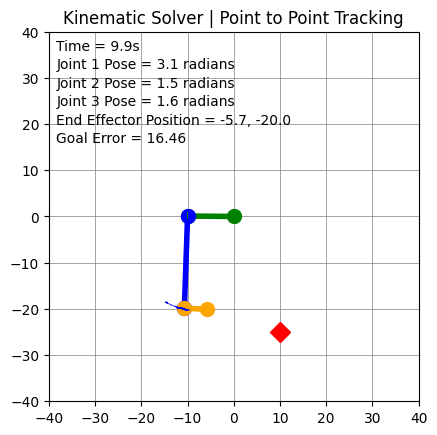

In [155]:
class RandomPlanner(object):
    def __init__(self):
        self.action_dim = 3
    
    def plan(self, z, t0=False):
        return np.random.uniform(-1, 1, self.action_dim)

model = ManipulatorModel(factored=False)
planner = RandomPlanner()
visualize_planner(model, planner, name='random')

## Standard MPPI

In [156]:
class MPPIPlanner(object):
    def __init__(self, model):
        self.model = model
        self.action_dim = 3
        self.discount_update = 1.0
        self.device = 'cpu'
        # MPPI hyperparameters
        self.iterations = 6
        self.num_samples = 50 # 512
        self.num_elites = 5 # 64
        self.num_pi_trajs = 24 # M: currently not used
        self.horizon = 4 # 3
        self.max_std = 2.0
        self.min_std = 0.05
        self.temperature = 0.5
        self.prev_means = np.zeros((self.horizon, self.action_dim))

    def _estimate_value(self, states, actions):
        """Estimate value of a trajectory starting at latent state z and executing given actions."""
        G, discount = [0]*self.num_samples, [1]*self.num_samples
        for t in range(self.horizon):
            for n in range(self.num_samples):
                tmp_z, reward, _, _ = self.model.step(states[n], actions[t,n])
                G[n] = G[n] + discount[n] * reward
                discount[n] = discount[n] * self.discount_update
                states[n] = tmp_z
        # M: future return
        # action, _ = self.model.pi(z, task)
        # return G + discount * self.model.Q(z, action, task, return_type='avg')
        return G

    def plan(self, z, t0=False):
        """
        Plan a sequence of actions using the learned world model.

        Args:
            z (torch.Tensor): Latent state from which to plan.
            t0 (bool): Whether this is the first observation in the episode.

        Returns:
            torch.Tensor: Action to take in the environment.
        """

        # Initialize state and parameters
        z = np.array(z)
        z = np.repeat(z[np.newaxis, :], self.num_samples, axis=0)
        mean = np.zeros((self.horizon, self.action_dim))
        std = np.full((self.horizon, self.action_dim), self.max_std)
        if not t0 and self.prev_means is not None:
            mean[:-1] = self.prev_means[1:]
        actions = np.empty((self.horizon, self.num_samples, self.action_dim))

        # Iterate MPPI
        for i in range(self.iterations):

            # Sample actions
            r = np.random.randn(self.horizon, self.num_samples, self.action_dim)
            actions_sample = mean[:, np.newaxis, :] + std[:, np.newaxis, :] * r
            actions_sample = np.clip(actions_sample, -1, 1)
            actions = actions_sample

            # Compute elite actions
            value = np.nan_to_num(self._estimate_value(z, actions))
            elite_idxs = np.argsort(value.squeeze())[-self.num_elites:]
            elite_value = value[elite_idxs]
            elite_actions = actions[:, elite_idxs]

            # Update parameters
            max_value = elite_value.max()
            score = np.exp(self.temperature * (elite_value - max_value))
            score = score / score.sum()
            mean = np.sum(score[np.newaxis, :, np.newaxis] * elite_actions, axis=1) / (score.sum() + 1e-9) # [horizon, state_dim]
            std = np.sqrt(np.sum(score[np.newaxis, :, np.newaxis] * (elite_actions - mean[:, np.newaxis, :]) ** 2, axis=1) / (score.sum() + 1e-9))
            std = np.clip(std, self.min_std, self.max_std)

        # Select action
        rand_idx = np.random.choice(self.num_elites, p=score)
        actions = elite_actions[:, rand_idx]
        a, std = actions[0], std[0]
        self.prev_means = mean
        return np.clip(a, -1, 1)

step: 0
[Warning] inverse_kinematic Solution is not optimal with error: 0.02689612093036003
[Warning] inverse_kinematic Solution is not optimal with error: 0.02689612093036003
[Warning] inverse_kinematic Solution is not optimal with error: 0.02689612093036003
[Warning] inverse_kinematic Solution is not optimal with error: 0.02689612093036003
[Warning] inverse_kinematic Solution is not optimal with error: 0.02689612093036003
[Warning] inverse_kinematic Solution is not optimal with error: 0.02689612093036003
[Warning] inverse_kinematic Solution is not optimal with error: 0.02689612093036003
[Warning] inverse_kinematic Solution is not optimal with error: 0.02689612093036003
[Warning] inverse_kinematic Solution is not optimal with error: 0.02689612093036003
[Warning] inverse_kinematic Solution is not optimal with error: 0.02689612093036003
[Warning] inverse_kinematic Solution is not optimal with error: 0.02689612093036003
[Warning] inverse_kinematic Solution is not optimal with error: 0.02

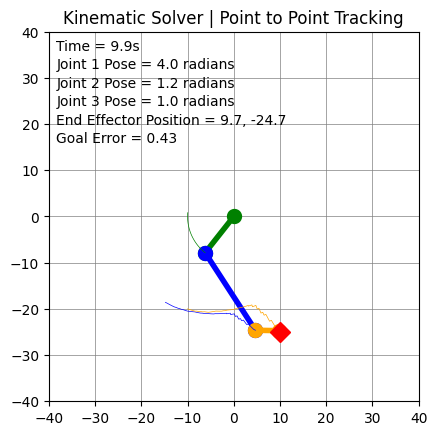

In [157]:

model = ManipulatorModel(factored=False)
mppi_planner = MPPIPlanner(model)
visualize_planner(model, mppi_planner, name='mppi')

## Factored MPPI

In [160]:
class FacMPPIPlanner(object):
    def __init__(self, model):
        self.model = model
        self.action_dim = 3
        self.discount_update = 1.0
        self.device = 'cpu'
        # MPPI hyperparameters
        self.iterations = 6
        self.num_samples = 50 # 512
        self.num_elites = 5 # 64
        self.num_pi_trajs = 24 # M: currently not used
        self.horizon = 4
        self.max_std = 2.0
        self.min_std = 0.05
        self.temperature = 0.5
        self.prev_means = np.zeros((self.horizon, self.action_dim))

    def _estimate_value(self, states, actions):
        """Estimate value of a trajectory starting at latent state z and executing given actions."""
        # states: [50, 3], actions: [h, 50, 3]
        # G: [50, 3]
        G, discount = [np.zeros((self.action_dim))]*self.num_samples, [np.ones((self.action_dim))]*self.num_samples
        for t in range(self.horizon):
            for n in range(self.num_samples):
                tmp_z, reward, _, _ = self.model.step(states[n], actions[t,n])
                G[n] = G[n] + discount[n] * reward
                discount[n] = discount[n] * self.discount_update
                states[n] = tmp_z
        # M: future return
        # action, _ = self.model.pi(z, task)
        # return G + discount * self.model.Q(z, action, task, return_type='avg')
        G = np.array(G)
        return G


    def plan(self, z, t0=False):
        """
        Plan a sequence of actions using the learned world model.

        Args:
            z (torch.Tensor): Latent state from which to plan.
            t0 (bool): Whether this is the first observation in the episode.

        Returns:
            torch.Tensor: Action to take in the environment.
        """

        # Initialize state and parameters
        z = np.array(z)
        z = np.repeat(z[np.newaxis, :], self.num_samples, axis=0)
        mean = np.zeros((self.horizon, self.action_dim))
        std = np.full((self.horizon, self.action_dim), self.max_std)
        if not t0 and self.prev_means is not None:
            mean[:-1] = self.prev_means[1:]
        actions = np.empty((self.horizon, self.num_samples, self.action_dim))

        # Iterate MPPI
        for i in range(self.iterations):

            # Sample actions
            r = np.random.randn(self.horizon, self.num_samples, self.action_dim)
            actions_sample = mean[:, np.newaxis, :] + std[:, np.newaxis, :] * r
            actions_sample = np.clip(actions_sample, -1, 1)
            actions = actions_sample # [h, num_samples, action_dim]

            # Compute elite actions
            value = np.nan_to_num(self._estimate_value(z, actions)) # [num_samples, action_dim]
            value = np.transpose(value.squeeze()) # [action_dim, num_samples]
            elite_idxs = np.argsort(value)[:, -self.num_elites:] # [action_dim, num_elites]
            elite_value = np.take_along_axis(value, elite_idxs, axis=1) # [action_dim, num_elites]
            elite_actions =  np.take_along_axis(np.transpose(actions, (0,2,1)), np.repeat(elite_idxs[np.newaxis, :, :], self.horizon, axis=0), axis=2) # [h, action_dim, num_elites]

            # Update parameters
            max_value = np.max(elite_value, axis=1, keepdims=True) # [action_dim, 1]
            score = np.exp(self.temperature * (elite_value - max_value)) # [action_dim, num_elites]
            score = score / np.sum(score, axis=1, keepdims=True)
            mean = np.sum(score[np.newaxis, :, :] * elite_actions, axis=2) / (np.sum(score[np.newaxis, :, :], axis=2) + 1e-9) # [horizon, action_dim]
            std = np.sqrt(np.sum(score[np.newaxis, :, :] * (elite_actions - mean[:, :, np.newaxis]) ** 2, axis=2) / (np.sum(score[np.newaxis, :, :], axis=2) + 1e-9))
            std = np.clip(std, self.min_std, self.max_std)

        # Select action
        rand_idx = [np.random.choice(self.num_elites, p=score[i]) for i in range(self.action_dim)] # [action_dim]
        a = np.array([elite_actions[0, i, rand_idx[i]] for i in range(self.action_dim)])
        self.prev_means = mean
        return np.clip(a, -1, 1)


step: 0
step: 1
step: 2
step: 3
step: 4
step: 5
step: 6
step: 7
step: 8
step: 9
step: 10
step: 11
step: 12
step: 13
step: 14
step: 15
step: 16
step: 17
step: 18
step: 19
step: 20
step: 21
step: 22
step: 23
step: 24
step: 25
step: 26
step: 27
step: 28
step: 29
step: 30
step: 31
step: 32
step: 33
step: 34
step: 35
step: 36
step: 37
step: 38
step: 39
step: 40
step: 41
step: 42
step: 43
step: 44
step: 45
step: 46
step: 47
step: 48
step: 49
step: 50
step: 51
step: 52
step: 53
step: 54
step: 55
step: 56
step: 57
step: 58
step: 59
step: 60
step: 61
step: 62
step: 63
step: 64
step: 65
step: 66
step: 67
step: 68
step: 69
step: 70
step: 71
step: 72
step: 73
step: 74
step: 75
step: 76
step: 77
step: 78
step: 79
step: 80
step: 81
step: 82
step: 83
step: 84
step: 85
step: 86
step: 87
step: 88
step: 89
step: 90
step: 91
step: 92
step: 93
step: 94
step: 95
step: 96
step: 97
step: 98
step: 99
Calculation Time: 10.659746170043945 seconds 
Control Steps: 100 Control Interval: 0.1


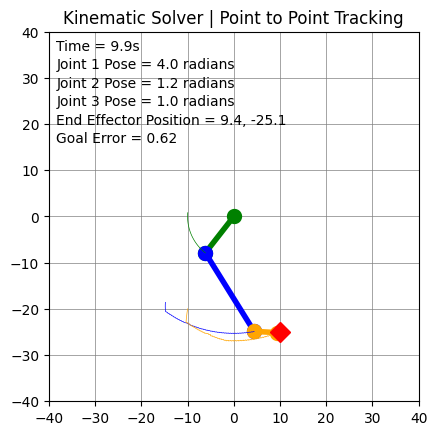

In [162]:

fac_model = ManipulatorModel(factored=True)
fac_mppi_planner = FacMPPIPlanner(fac_model)
visualize_planner(fac_model, fac_mppi_planner, name='fac_mppi')